In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def get_sliding_window_mask(seq_len, window_size):
    # Create a basic causal mask (lower triangular)
    mask = torch.tril(torch.ones(seq_len, seq_len))
    
    # Create a mask that keeps only the 'window_size' diagonal
    # This removes tokens that are too far in the past
    window_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=-window_size + 1)
    
    # Combine them: only look back up to window_size, and never look forward
    final_mask = mask * window_mask
    return final_mask # Shape: (seq_len, seq_len)

In [4]:
class SlidingWindowAttention(nn.Module):
    def __init__(self, d_model, num_heads, window_size):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.window_size = window_size
        self.head_dim = d_model // num_heads
        
        self.qkv = nn.Linear(d_model, d_model * 3)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # 1. Project to Q, K, V and split heads
        # Resulting shape: (batch, seq_len, 3, heads, head_dim)
        qkv = self.qkv(x).reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        
        # 2. Rearrange to (batch, heads, seq_len, head_dim)
        q, k, v = qkv.permute(2, 0, 3, 1, 4) 

        # 3. Compute attention scores: (batch, heads, seq_len, seq_len)
        attn_scores = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        
        # 4. Apply the Sliding Window Mask
        mask = get_sliding_window_mask(seq_len, self.window_size).to(x.device)
        # Broadcasting the mask across batch and heads
        attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))
        
        # 5. Softmax and Apply weights to V
        attn_weights = F.softmax(attn_scores, dim=-1)
        # Result: (batch, heads, seq_len, head_dim)
        context = attn_weights @ v
        
        # 6. Concat heads and project out
        output = context.transpose(1, 2).reshape(batch_size, seq_len, self.d_model)
        
        return self.out(output), attn_weights

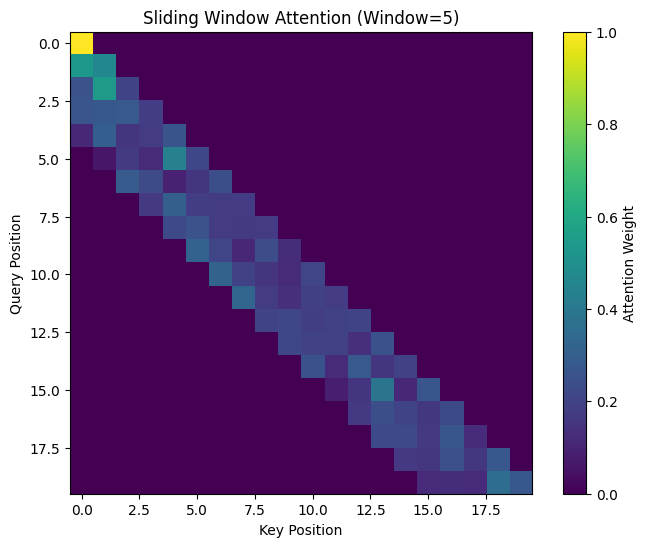

In [5]:
import matplotlib.pyplot as plt

# Parameters
seq_len = 20
window_size = 5
d_model = 64

# Initialize layer and dummy input
swa_layer = SlidingWindowAttention(d_model=d_model, num_heads=1, window_size=window_size)
dummy_input = torch.randn(1, seq_len, d_model)

# Forward pass
output, weights = swa_layer(dummy_input)

# Plot the attention matrix for the first head
plt.figure(figsize=(8, 6))
plt.imshow(weights[0, 0].detach().numpy(), cmap='viridis')
plt.title(f"Sliding Window Attention (Window={window_size})")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.colorbar(label="Attention Weight")
plt.show()